# Convolution + LSTM Temperature prediction - many to one problem





## Data

In [0]:
%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
from pandas import Series
from pandas.plotting import scatter_matrix
import datetime
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

TensorFlow 2.x selected.


In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

13574144/13568290 [==============================] - 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90bd4d4b38>,
      dtype=object)

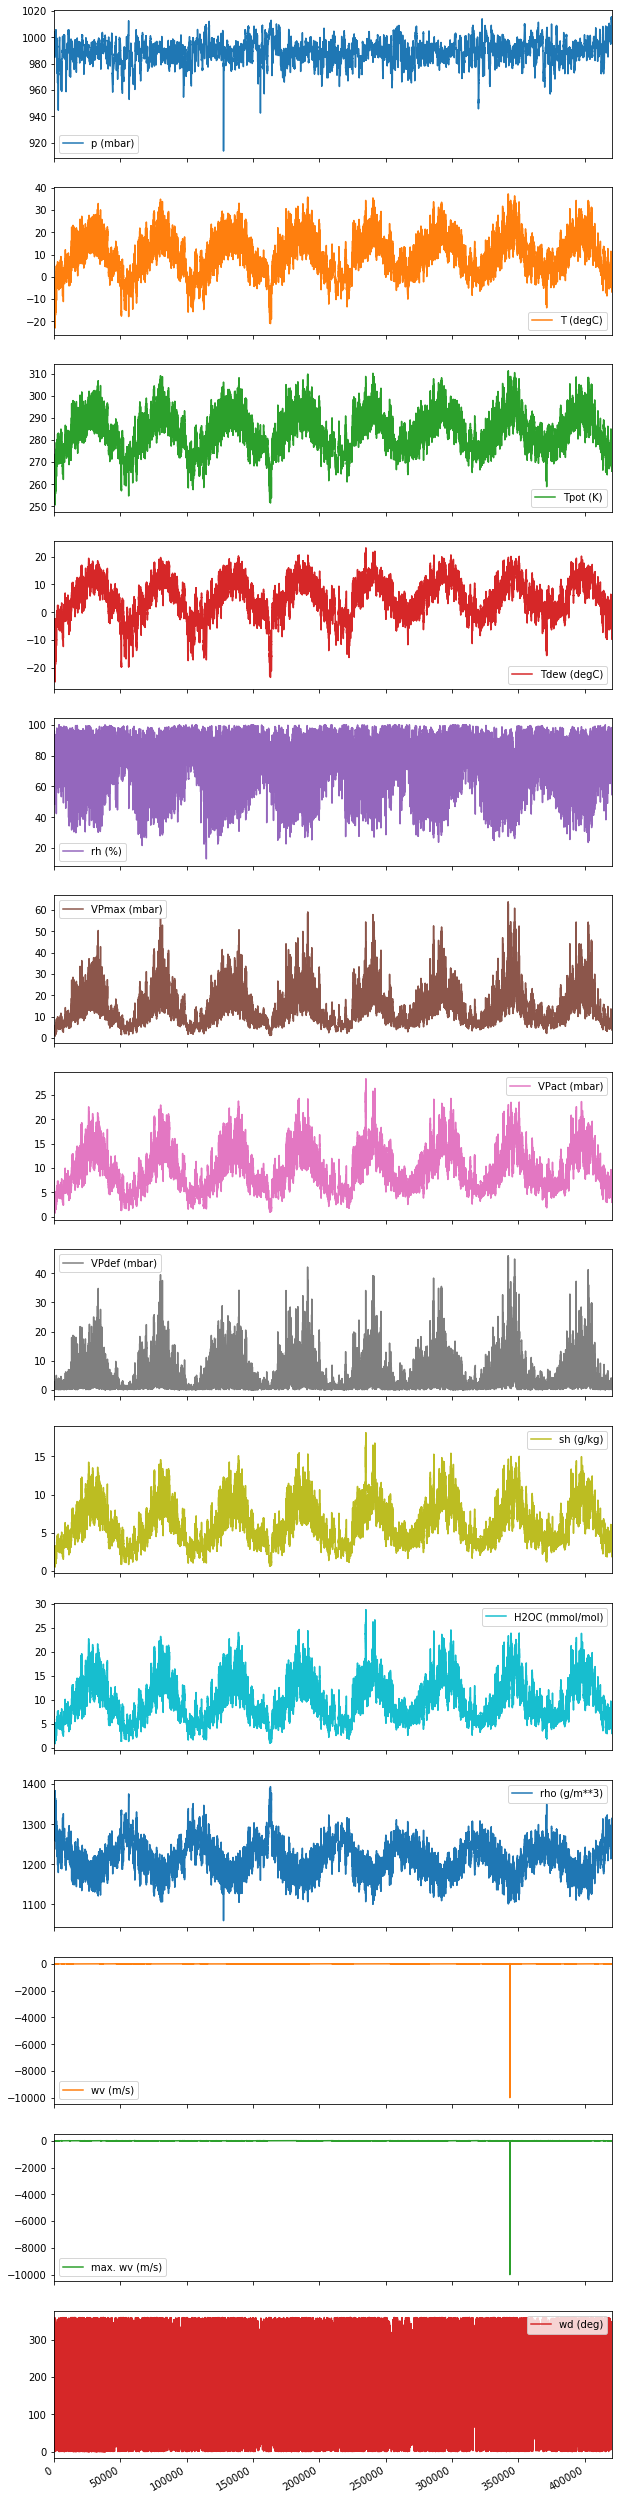

In [0]:
df.plot(subplots=True, figsize=(10,50))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90ba88b470>],
      dtype=object)

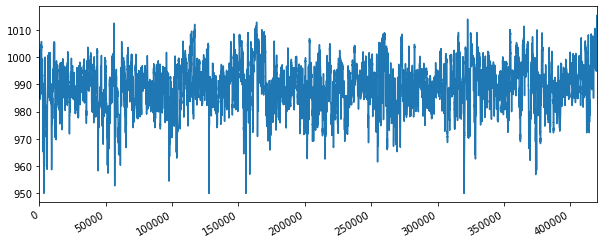

In [0]:
# clip 'p (mbar)'
df['p (mbar)'] = df['p (mbar)'].clip(lower=950)
df['p (mbar)'].plot(subplots=True, figsize=(10,4))

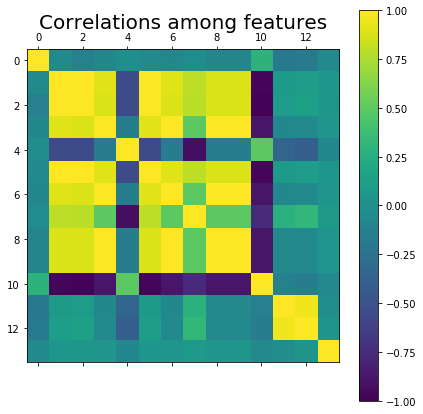

In [0]:
# Correlations among features
fig = plt.figure(figsize=(7,7))
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1, fignum=fig.number)
plt.title('Correlations among features', size=20)
plt.colorbar()
plt.show()

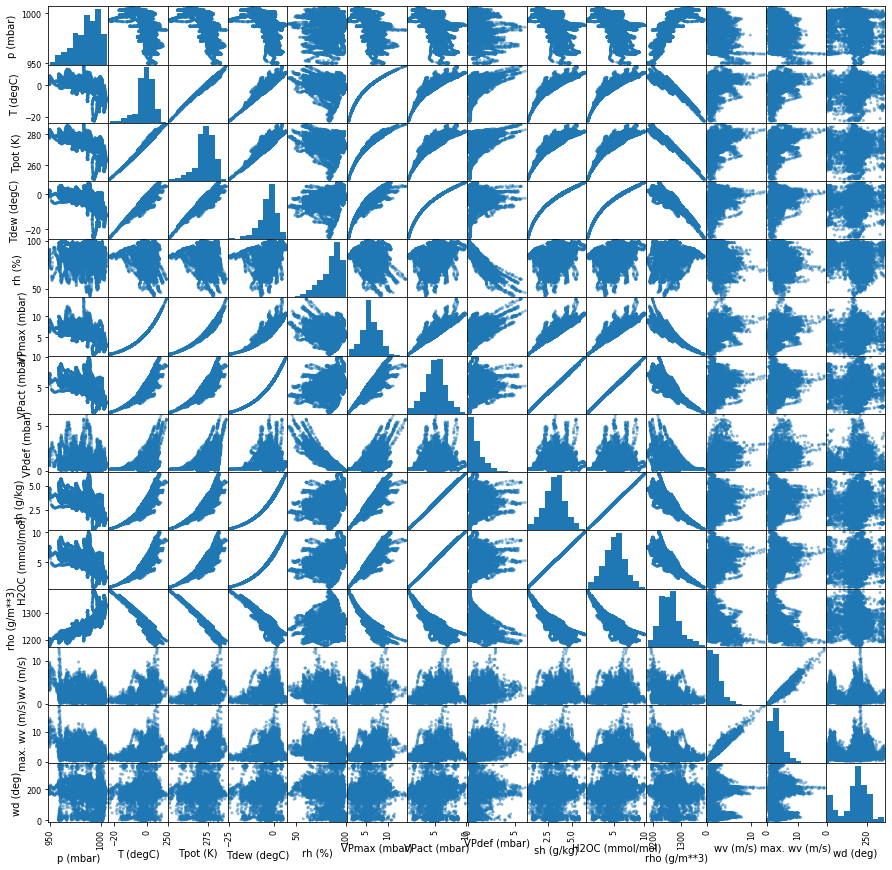

In [0]:
scatter_matrix(df.head(10000), figsize=(15, 15))
plt.show()

In [0]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

Hours:  70091 
Days:  2920 
Weeks:  417 
Years:  8


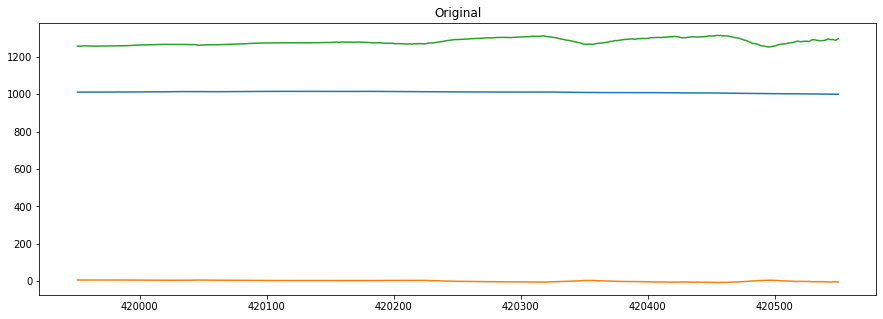

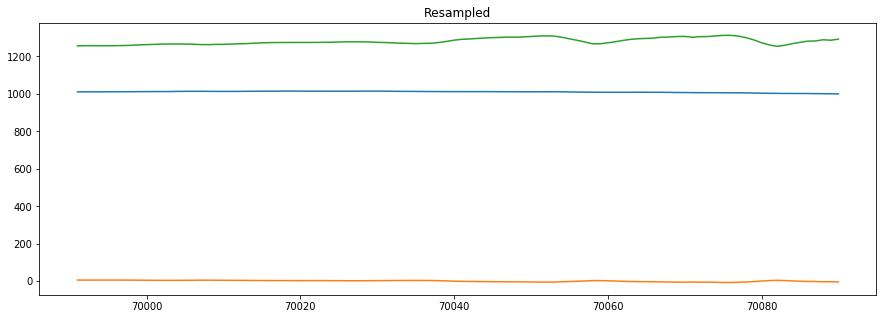

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
df_data = df[features_considered]

# Resample: 10min -> 1h
def resample(data, sample_rate):
  output_data = []
  for feature_index in range(0, data.shape[1]): #For every feature
    resampled_data = []
    for sample_index in range(sample_rate, len(data[:,feature_index]), sample_rate): # For every sample
      resampled_data.append(np.mean(data[sample_index-sample_rate:sample_index,feature_index]))
    output_data.append(resampled_data)
  
  return np.transpose(np.asarray(output_data))

fig = plt.figure(figsize=(15,5))
plt.plot(df_data.tail(600))
plt.title('Original')

np_data = np.asarray(df_data)
np_data = resample(np_data, 6)
df_data = pd.DataFrame(data=np_data, columns=features_considered)
fig = plt.figure(figsize=(15,5))
plt.plot(df_data.tail(100))
plt.title('Resampled')

data_length = np_data[:,0].shape[0]
print('Hours: ', data_length, '\nDays: ', int(data_length/24), '\nWeeks: ', int(data_length/24/7), '\nYears: ', int(data_length/24/365))

In [0]:
# Derivative of time series (it's better without derivative)
# fig = plt.figure(figsize=(15,5))
# plt.plot(df_data.tail(100))
# plt.title('Original')

# df_data = pd.Series.diff(df_data)
# df_data = df_data.drop(df_data.index[0])
# fig = plt.figure(figsize=(15,5))
# plt.plot(df_data.tail(100))
# plt.title('Differenced')

# np_data = np.asarray(df_data)

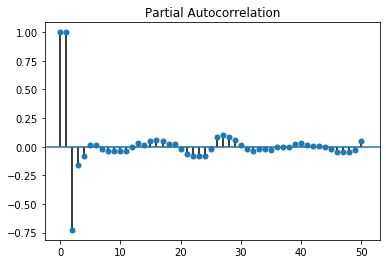

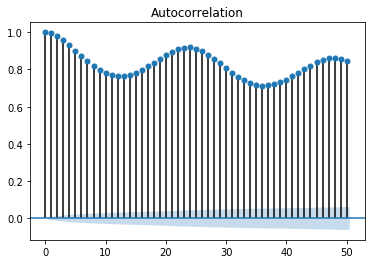

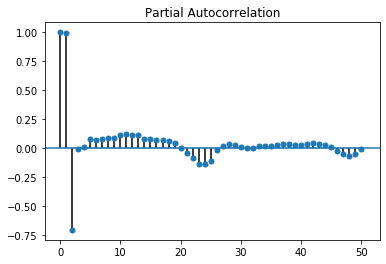

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(np_data[:,0], lags=50)
plt.show()
plot_acf(np_data[:,1], lags=50)
plt.show()
plot_pacf(np_data[:,2], lags=50)
plt.show()

In [0]:
# Normalize to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_data)
np_data = scaler.transform(df_data)
df_data = pd.DataFrame(data=np_data, columns=features_considered)

Text(0.5, 1.0, 'Normalized')

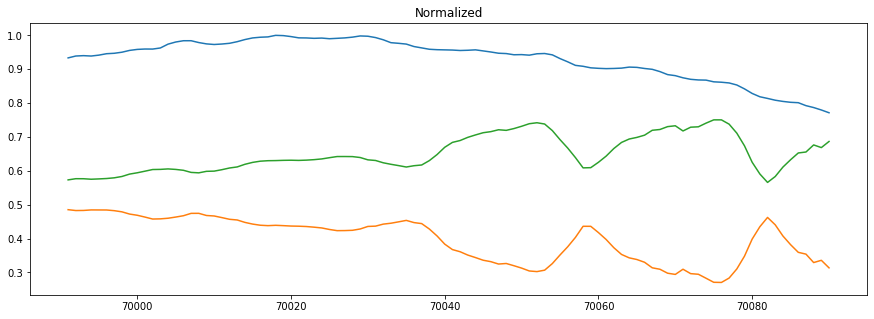

In [0]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_data.tail(100))
plt.title('Normalized')

## Data pipeline

![alt text](https://raw.githubusercontent.com/KrzysztofV/colab-lstm-temperature-prediction/master/data.png)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
  """
  Creates dataset using sliding window method.
  dataset: input data
  target: output data
  start_index, end_index: for dividing dataset
  history_size: training data size
  target_size: forecasting data size
  step: spacing between windows
  """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    indices = range(i, i+target_size)
    labels.append(target[indices])

  return np.array(data), np.array(labels)

past_history = 12*10
step = 12
future_target = 12
split_index = int(len(np_data)*7/8) # 7 years train, 1 year test

x_train, y_train = multivariate_data(np_data, np_data[:, 1], 0, split_index, past_history, future_target, step)
x_val, y_val = multivariate_data(np_data, np_data[:, 1], split_index, None, past_history, future_target, step)

# Data pipeline
batch_size = 50
encoder_input_data = x_train
decoder_input_data = y_train
decoder_target_data = np.expand_dims(y_train, axis=-1)
train_data = tf.data.Dataset.from_tensor_slices((x_train, np.expand_dims(y_train, axis=-1)))
train_data = train_data.cache().batch(batch_size, drop_remainder=True).shuffle(buffer_size=1000).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, np.expand_dims(y_val, axis=-1)))
val_data = val_data.batch(batch_size).repeat()

print('Number of train batches: ', int(x_train.shape[0]/batch_size))
print('Number of validation batches: ', int(x_val.shape[0]/batch_size))
print('Sum of input data [hours] in one batch: ', step*batch_size+past_history)

Number of train batches:  85
Number of validation batches:  12
Sum of input data [hours] in one batch:  732


In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)

  return time_steps

def plot_prediction(history, true_future, prediction):
  plt.figure(figsize=(15, 3))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.title('Temperature')
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'g', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r', label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

# Plot 5 examples from batch
for x, y in val_data.take(1):
  for i in range(0, 5):
    plot_prediction(x[i], y[i], np.array([0]))

input_shape = x[i].shape
output_shape = y[i].shape

print('Input data shape (timesteps, features): ', input_shape)
print('Output data shape (timesteps, features): ', output_shape)

## Training

![alt text](https://raw.githubusercontent.com/KrzysztofV/colab-lstm-temperature-prediction/master/training.png)

In [0]:
log_dir="logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

checkpoint_path = "logs/ckpt/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, period=1)

def learning_rate_scheduler(epoch):
  learning_rate = 0.0001
  if epoch >= 30:
    learning_rate = 0.00005
  return learning_rate
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

for x, y in val_data.take(1):
  x_vis = x
  y_vis = y
class custom_callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    prediction = model.predict(x_vis)[-1] # last prediction
    plot_prediction(x_vis[-1], y_vis[-1], prediction) 

def build_model(input_shape, n_outputs):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*4, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*4, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D())
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*8, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*8, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.MaxPooling1D())
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*12, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*12, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.MaxPooling1D())
  model.add(tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.1))
  model.add(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.1))
  model.add(tf.keras.layers.LSTM(64, recurrent_dropout=0.1))
  model.add(tf.keras.layers.Dense(12))
  optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
  model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
  return model

model = build_model(input_shape, output_shape[0])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
%tensorboard --logdir "/logs/"  --port 6008

In [0]:
! rm -r '/content/logs'

In [0]:
epochs = 100
history = model.fit(train_data, 
                    epochs=epochs, 
                    initial_epoch = 0,
                    steps_per_epoch=int(x_train.shape[0]/batch_size), 
                    validation_data=val_data, 
                    validation_steps=int(x_val.shape[0]/batch_size), 
                    validation_freq = 1,
                    callbacks=[tensorboard_callback, 
                               checkpoint_callback, 
                               learning_rate_callback, 
                               custom_callbacks()])

In [0]:
# Loads the weights from the best checkpoint
model.load_weights('logs/ckpt/cp-0012.ckpt')

## Evaluation

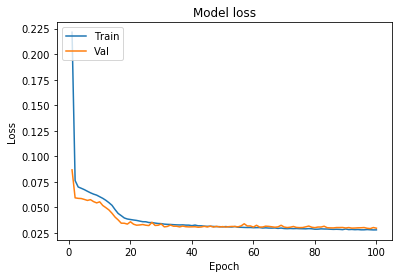

In [0]:
def plot_learningCurve(history, epochs):
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, epochs)

In [0]:
# Comparing prediction with true data - all validation batches
for x, y in val_data.take(int(x_val.shape[0]/batch_size)):
  prediction = model.predict(x)[-1]
  plot_prediction(x[-1], y[-1], prediction)

In [0]:
# Comparing prediction with true data - all train batches
for x, y in train_data.take(int(x_train.shape[0]/batch_size)):
  prediction = model.predict(x)[-1]
  plot_prediction(x[-1], y[-1], prediction)